#Architecture Transformer et affinage

- [BertViz](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing#scrollTo=T3H0qUZvPOP4), [HuggingFace](https://huggingface.co/docs/transformers/tasks/translation)
- [Tutoriel Pytorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
- [Cours général](https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf)
- [Documentation de HuggingFace](https://huggingface.co/docs/transformers/index)

## Introduction

L'architecture Transformer, dont l'invention remonte à 2017 dans l'article [Attention Is All You Need](https://arxiv.org/abs/1706.03762), est depuis plusieurs années l'état de l'art de la traduction automatique neuronale, ainsi que de beaucoup d'autres tâches de traitement automatique des langues.

Les modèles sont de type encoder-décodeur. Dans les Transformer, l'encodeur utilise un mécanisme dit d'auto-attention (*self-attention*) sur les couches d'entrée, tandis que le décodeur combine l'auto-attention avec l'attention sur l'encodeur. Contrairement aux RNN, aucune récurrence n'est utilisée, et le modèle peut digérer un texte entier en une seule itération. De ce fait, un modèle transformer est plus rapide à entraîner et à utiliser.

In [ ]:
# Installation des bibliothèques. Bertviz est un outil pour la visualisation
# de l'attention dans les modèles de type Transformer (BERT, GPT-2, Albert, XLNet, RoBERTa, CTRL, etc.)
!pip install transformers[torch] datasets evaluate sacrebleu bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.

In [ ]:
# Datasets : Gestion des jeux de données, pour une utilisation facile avec la bibliothèque transformers
# Transformers : Gestion de modèles neuronaux d'architecture Transformer
# Bertviz : Visualisation de l'attention dans un modèle Transformer
# Evaluate : Évaluation des performances du modèle
# Matplotlib : Visualisation sous forme de graphiques
# Numpy : Gestion des matrices et des données numériques

from datasets import load_dataset
from transformers import T5Tokenizer, AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline
from transformers import T5ForConditionalGeneration, T5Tokenizer
from bertviz import head_view, model_view

import evaluate
import matplotlib.pyplot as plt

import numpy as np
import random

# Corpus de traduction et préparation
(Un système de traduction de l'anglais vers le français)

Le jeu de données -> [OPUS book](https://huggingface.co/datasets/opus_books).

Il s'agit d'une collection de textes alignés en plusieurs langues. On rappelle que pour entraîner un modèle de traduction, il est nécessaire d'avoir des données parallèles, c'est-à-dire d'une collection de phrases sources et de traductions de référence alignées phrase par phrase et stockées dans deux fichiers, de telle sorte que chaque ligne du fichier de référence soit la traduction de la même ligne dans le fichier source.

Dans cet exemple, on télécharge et prétraite les données parallèles à partir du [hub de HuggingFace](https://huggingface.co/). Il s'agit d'une plateforme en ligne stockant de nombreux jeux de données et de modèles Transformer pré-entrainés. La bibliothèque `transformers` gère le chargement des modèles, tandis que la bibiliothèque `datasets` perlet de charger les jeux de données.

(Pour pouvoir travailler plus rapidement, on réduit la taille du jeu de données.)




In [ ]:
# Téléchargement du jeu de données OPUS books (sous-jeu de données anglais-français) depuis le hub
books = load_dataset("opus_books", "en-fr")

# Sélection de maximum 3000 points de données, sélectionnés aléatoirement
n_datapoints = len(books["train"])
n_datapoints_to_keep = min(n_datapoints, 3000)

random_indices = random.sample(range(n_datapoints), n_datapoints_to_keep)
dataset = books.filter(lambda example, idx: idx in random_indices, with_indices=True)

# Séparation automatique en jeu d'entraînement et jeu de validation
# Attention : Il ne s'agit pas de la fonction habituelle de `scikit-learn`,
# mais de celle de `datasets`. Celle-ci modifie le jeu de données en place.
dataset = dataset["train"].train_test_split(test_size=0.1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Filter:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [ ]:
# Le jeu de données a été automatiquement divisé
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 2700
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 300
    })
})

certains examples de notre jeu de données

In [ ]:
for i in range(4):
  print(dataset["train"][i])

{'id': '109282', 'translation': {'en': "Amongst other documents, a sheet of paper, carefully folded, bore the heading of the Danish consulate with the signature of W. Christiensen, consul at Hamburg and the Professor's friend.", 'fr': "Entre autres, une feuille de papier, pliée avec soin, portait l'entête de la chancellerie danoise, avec la signature de M. Christiensen, consul à Hambourg et l'ami du professeur."}}
{'id': '41013', 'translation': {'en': 'I know him for a Norman, and Normans are obstinate."', 'fr': 'Je le reconnais pour un Normand et les Normands sont entêtés.»'}}
{'id': '123811', 'translation': {'en': 'She returned to Vernon beaming with pleasure, relating that she had found a gem, a delightful little place right in the centre of Paris.', 'fr': "Elle revint rayonnante à Vernon, elle dit qu'elle avait trouvé une perle, un trou délicieux, en plein Paris."}}
{'id': '28279', 'translation': {'en': 'They meet, they write, there is a complete understanding between them.', 'fr':

# Modèle Transformer

L'architecture [Transformer](https://arxiv.org/abs/1706.03762) est actuellement l'état de l'art pour beaucoup de tâches du TALN, et notamment pour la traduction automatique. Au sein de cette architecture, l'encodeur utilise en générale un bloc d'auto-attention sur les couches précédentes, tandis que le décodeur combine un bloc d'auto-attention ainsi qu'un bloc dit d'attention encodeur-décodeur.


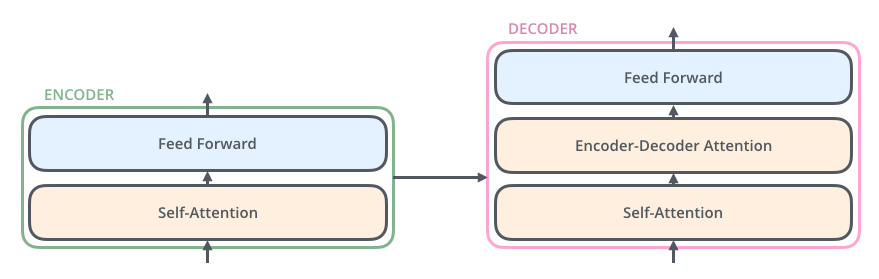

*Image tirée de [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)*

La figure ci-dessus montre un bloc de l'encodeur et un bloc du décodeur. En pratique, l'encodeur comme le décodeur sont constitués de multiple blocs, "empilés" les uns sur les autres.

On rappelle que l'architecture Transformer est principalement basée sur le mécanisme d'auto-attention, qui permet de mesurer la force de la relation entre chaque paire de tokens. En général, on n'a pas une seule, mais plusieurs têtes d'attention (*attention heads*) au sein de chaque bloc, chaque tête pouvant en théorie apprendre un type de relation différent. C'est ce qu'on appelle l'attention multi-tête (*multihead attention*).

La force de la relation entre les différents tokens sur une attention multi-tête peut être facilement visualisée. Par exemple, voici une représentation de l'auto-attention pour la phrase "The animal didn't cross the street because it was too tired" dans un modèle de type Transformer :


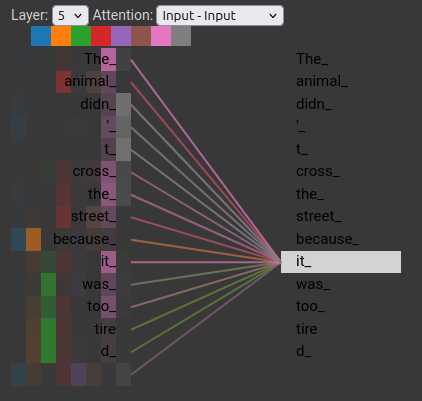

## Questions
Cette figure est extraite de [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/). En vous aidant si besoin de cette page web, expliquez :
1. Que représentent les séquences de tokens à gauche et à droite ?
2. Que représentent les liens entre les tokens ?
3. Que représente les differentes couleurs ?
4. À quoi fait référence "layer" ?
5. À votre avis, quelle tête gère ici la résolution de coréférences, c'est-à-dire le fait de savoir à quel nom correspond le pronom "it" ?

Réponse:

1. Les séquences à gauche et à droite représentent les tokens d'entrée et de sortie du modèle Transformer.

2. Les liens montrent les attentions du modèle entre les tokens.

3. Chaque couleur correspond à une tête d'attention différente dans le mécanisme d'attention multi-têtes du modèle Transformer. Cela permet au modèle de capturer différentes relations contextuelles entre les mots.

4. Un layer (ou couche) désigne une étape ou un niveau dans l'architecture du Transformer.

5. La tête qui gère probablement la coréférence est celle qui établit un lien entre "it" et "animal".

# Modèle et tokenization
Un modèle de langage pré-entrainé appelé T5:

 Il s'agit d'une série de modèles open-source seq2seq (encodeur-décodeur) de type Transformer publiés par Google en 2019. Ces modèles ont été entraînés sur une grande diversité de tâches et de données textuelles.

Le modèle `T5-small`, est la version la plus petite de T5.

Un des nombreux avantages de travailler avec un modèle pré-entraîné est que le tokenizer pour celui-ci a également déjà été entraîné. On peut le charger et l'utiliser directement !

La première étape va consister à évaluer ses performances de base.

Pour utiliser un modèle multi-tâche de type seq2seq comme T5, on insère un prefix à nos examples, pour indiquer au modèle pre-entrainé la tâche que l'on souhaite réaliser.

In [ ]:
# Nom du modèle pre-entrainé que l'on va utiliser pour le moment
model_checkpoint = " "

# Chargement du tokenizer aussi pre-entrainé specialement pour ce modèle.
# La classe `AutoTokenizer` détecte automatiquement le type de tokenizer (ici, un BPE).
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, padding=True)

source_lang = "en"
target_lang = "fr"
# Le prefix donne une instruction au modèle pour effectuer la tâche que l'on souhaite
prefix = "Translate from English to French: "

def preprocess_function(examples):
    # Avant de tokenizer le texte, on lui ajoute le préfixe
    model_inputs = []
    for ex in examples:
        inputs = prefix + ex['translation'][source_lang] + '</s>'
        targets = ex['translation'][target_lang] + '</s>'
        model_inputs.append(tokenizer(inputs, text_target=targets, max_length=64, truncation=True))
    return model_inputs

# Application du pré-traitement à l'ensemble du dataset
tokenized_books_train = preprocess_function(dataset["train"])
tokenized_books_dev = preprocess_function(dataset["test"])

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

## Chargement du modèle T5 pré-entrainé

On utilise les fonctions de HuggingFace pour charger le modèle, en utilisant simplement le nom du modèle (ici `t5-small)`. Tout comme `AutoTokenizer`, la classe `AutoModel` détecte automatiquement le sous-type d'architecture Transformer dans le modèle et l'instancie correctement.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to("cuda:0")
model

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

# Affinage du modèle

Le modèle que nous avons téléchargé a été entraîné sur de grandes quantités de données et "comprend" assez bien le langage naturel. Nous souhaitons désormais utiliser notre jeu de données pour l'affiner, c'est-à-dire le spécialiser dans la tâche de traduction qui nous intéresse.

Comme le modèle est déjà assez performant, cet affinement n'aura pas besoin de durer très longtemps; il s'agit simplement de modifier légèrement ses poids afin d'augmenter ses performances.

#### Construction des lots (batches).
Les lots sont automatiquement mélangés (shuffled) avant chaque époque.
Pour cela, on utilise un Collator, qui performe automatiquement le batching et padding.

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_checkpoint, max_length=64, padding=True)


Pour évaluer les performances d'un modèle (durant ou après l'entraînement), il est utile d'include une métrique correspondant à la tâche sur laquelle on souhaite évaluer le modèle. La bibliothèque [`evaluate`](https://huggingface.co/docs/evaluate/index) permet de facilement charger un certain nombre de métriques standard d'évaluation.

Pour la traduction, on va utiliser la métrique [SacreBLEU](https://huggingface.co/spaces/evaluate-metric/sacrebleu) mentionnée au dernier TP. La documentation d'`evaluate` contient plus d'information sur la manière dont ont peu charger et calculer une métrique.

In [ ]:
metric = evaluate.load("sacrebleu")

# Les fonctions de post-traitement dépendent grandement du type de modèle utilisé.
# Ces détails techniques ne sont pas à mémoriser et peuvent être trouvés dans la documentation de chaque type de modèle.
# Par exemple, pour T5 : https://huggingface.co/docs/transformers/en/model_doc/t5
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    result = {k: round(v, 4) for k, v in result.items()}
    return result

## Programmation de l'apprentissage

Comme toujours, l'apprentissage est itératif et s'effectue sur un certain nombre d'époques. Pour vérifier si l'apprentissage évolue positivement, nous utiliserons la mesure BLEU vue précédemment, conjointement avec la fonction de cout (*loss*), pour évaluer le modèle à chaque pas d'itération.

Le code ci-dessous utilise les classes de HuggingFace, notamment la classe `Seq2SeqTrainer` qui contient les paramètres décrivant l'entraînement ou affinage que l'on souhaite exécuter.



In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="opus_books_en_fr_model",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=12,
    generation_max_length=64,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books_train,
    eval_dataset=tokenized_books_dev,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


## Evaluation du modèle pre-entrainé

Le modèle T5 est déjà capable d'effectuer de bonnes prédictions de traductions sans affinage. On peut mesurer ses performances, en mesurant par exemple le score BLEU sur l'ensemble de test :

In [ ]:
results = trainer.evaluate()
results['eval_bleu']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


12.9464

Ici, le score obtenu est malgré tout faible, car il s'agit du plus petit modèle de la série T5. La petite taille d'un modèle pénalise en effet ses capacités, surtout lorsque celui-ci doit apprendre à effectuer un grand nombre de tâches à la fois !

## Exécution de l'affinage

Astuce : vous pouvez régler `epoch` sur une petite valeur (par exemple, 2) dans la cellule plus haut, et relancer la cellule ci-dessous plusieurs fois pour continuer à entraîner votre modèle (`train()` ne réinitialise pas le modèle).

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Bleu
1,2.114200,1.972354,0.004200,14.026600
2,2.026700,1.933596,0.004200,14.488500
3,1.974500,1.908292,0.004200,14.749500
4,1.935900,1.890366,0.004200,14.754400
5,1.913500,1.879295,0.004200,15.304500
6,1.885300,1.870626,0.004200,15.444300
7,1.875600,1.864135,0.004200,15.683300
8,1.861100,1.859639,0.004200,15.675200
9,1.848200,1.856277,0.004200,15.886600
10,1.836200,1.854565,0.004200,15.995100


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

TrainOutput(global_step=1020, training_loss=1.9117194531010646, metrics={'train_runtime': 415.4211, 'train_samples_per_second': 77.993, 'train_steps_per_second': 2.455, 'total_flos': 548031732252672.0, 'train_loss': 1.9117194531010646, 'epoch': 12.0})

On peut visualiser les courbes d'apprentissage and utilisant l'historique de la classe d'entraînement d'HuggingFace :

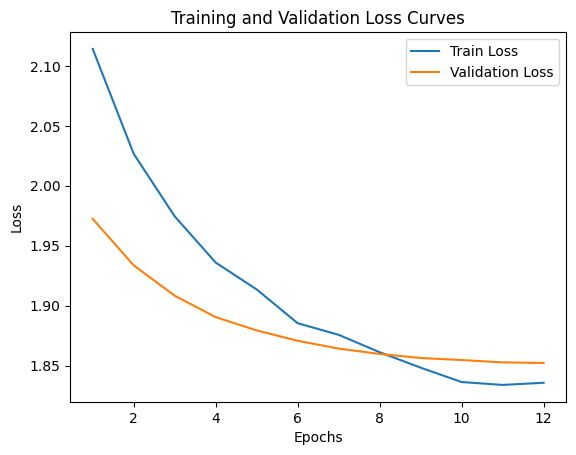

In [ ]:
# Récupération de l'historique
log_history = trainer.state.log_history

eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_epochs = [entry['epoch'] for entry in log_history if 'eval_loss' in entry]

train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]
train_epochs = [entry['epoch'] for entry in log_history if 'loss' in entry]

# Affichage
plt.plot(train_epochs, train_losses, label="Train Loss")
plt.plot(eval_epochs, eval_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

## Evaluation du modèle affiné

In [ ]:
results = trainer.evaluate()
results['eval_bleu']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


16.0699

## Prédiction avec le modèle affiné

Huggingface simplifie le processus de prédiction en offrant une classe appelée `Pipeline`, qui permet de faire des prédictions à partir d'un modèle pre-entrainé.

In [ ]:
text = "Translate from English to French: My neighbor's black cat eats mice."

translator = pipeline("translation_en_to_fr", model=model, tokenizer=tokenizer, device=0)
translator(text)

[{'translation_text': 'Le chat noir de mon voisin mange des souris.'}]

## Test interactif du modèle et visualisation des matrices d'attention

Le code suivant enregistre le modèle, puis propose deux visualisations interactives permettant d'observer le contenu des têtes d'attention à chaque couche grâce aux fonctions fournies par `bertviz`.

In [ ]:
trainer.save_model("opus_books_en_fr_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 300, 'early_stopping': True, 'num_beams': 4}


In [ ]:
def visualize_encoder_decoder(source_text, predicted_text, model=T5ForConditionalGeneration.from_pretrained("opus_books_en_fr_model"), tokenizer=T5Tokenizer.from_pretrained("t5-small")):
  inputs = tokenizer(
      source_text,
      return_tensors="pt",
  )

  with tokenizer.as_target_tokenizer():
      decoder_input_ids = tokenizer(predicted_text, return_tensors="pt", add_special_tokens=True).input_ids

  # On fournit à nouveau les sorties au modèle afin de lire les scores d'attention
  out = model(**inputs, decoder_input_ids=decoder_input_ids, output_attentions=True, return_dict=True)
  encoder_attentions = out.encoder_attentions
  cross_attentions = out.cross_attentions
  decoder_attentions = out.decoder_attentions

  encoder_text = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
  decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

  model_view(
        encoder_attention=encoder_attentions,
        decoder_attention=decoder_attentions,
        cross_attention=cross_attentions,
        encoder_tokens= encoder_text,
        decoder_tokens = decoder_text
    )

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Visualisation des têtes d'attention pour le modèle entier; cliquez sur une tête pour plus de détails

source_text = "Translate from English to French: My neighbor's black cat eats mice."
predicted_text = translator(source_text)[0]["translation_text"]

visualize_encoder_decoder(source_text, predicted_text)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


<IPython.core.display.Javascript object>

In [ ]:
def visualize_encoder_decoder_heads(source_text, predicted_text, model=T5ForConditionalGeneration.from_pretrained("opus_books_en_fr_model"), tokenizer=T5Tokenizer.from_pretrained("t5-small")):
  inputs = tokenizer(
      source_text,
      return_tensors="pt",
  )

  with tokenizer.as_target_tokenizer():
      decoder_input_ids = tokenizer(predicted_text, return_tensors="pt", add_special_tokens=True).input_ids

  out = model(**inputs, decoder_input_ids=decoder_input_ids, output_attentions=True, return_dict=True)
  encoder_attentions = out.encoder_attentions
  cross_attentions = out.cross_attentions
  decoder_attentions = out.decoder_attentions

  encoder_text = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
  decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

  head_view(
        encoder_attention=encoder_attentions,
        decoder_attention=decoder_attentions,
        cross_attention=cross_attentions,
        encoder_tokens= encoder_text,
        decoder_tokens = decoder_text
    )

In [ ]:
# Visualisation tête par tête. Vous pouvez cliquer sur les couleurs individuelles
# pour sélectionner/déselectionner des têtes, et double-cliquer pour n'afficher qu'une tête.

source_text = "Translate from English to French: My neighbor's black cat eats mice."
predicted_text = translator(source_text)[0]["translation_text"]

visualize_encoder_decoder_heads(source_text, predicted_text)

<IPython.core.display.Javascript object>

# Entraînement à partir de zéro

Pour le moment, on a vu comment affiner un modèle pré-entraîné.

Il est également possible de pré-entraîner soi-même un modèle à partir de zéro.

Ici, on va entraîner un modèle qui utilise la même architecture que l'encoder-decoder T5, mais qui n'est pas entraîné (les poids sont initialisés aléatoirement).

In [ ]:
configuration = model.config

# Création d'un nouveau modèle (poids aléatoires) en gardant la même configuration que le modèle précédent
model_from_scratch = T5ForConditionalGeneration(configuration)

# Nouvelle instance d'entraînement, mais qui réutilise le même jeu de données et paramètres d'entraînement
trainer_from_scratch = Seq2SeqTrainer(
    model=model_from_scratch,
    args=training_args,
    train_dataset=tokenized_books_train,
    eval_dataset=tokenized_books_dev,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


La performance d'un modèle initialisé aléatoirement est, comme on peut l'imaginer, très mauvaise :

In [ ]:
results = trainer_from_scratch.evaluate()
results['eval_bleu']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


0.0036

Nous allons maintenant entraîner le modèle, puis observer à nouveau le résultat.

In [ ]:
trainer_from_scratch.train()
results = trainer_from_scratch.evaluate()
results['eval_bleu']

Epoch,Training Loss,Validation Loss,Model Preparation Time,Bleu
1,7.955200,7.311671,0.006300,0.114300
2,7.193100,6.961860,0.006300,0.114800
3,6.917100,6.768453,0.006300,0.069200
4,6.737200,6.651137,0.006300,0.092500
5,6.618600,6.563344,0.006300,0.079200
6,6.509100,6.493515,0.006300,0.068800
7,6.428000,6.452442,0.006300,0.067500
8,6.351800,6.411242,0.006300,0.132100
9,6.290400,6.387674,0.006300,0.168100
10,6.244700,6.368488,0.006300,0.130100


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 300, 'early_stopping': True, 'num_beams': 4}
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 300, 'early_stopping': True,

0.1714